## Astronomy 406 "Computational Astrophysics" (Fall 2024)

## Project 7

### Background

In this project we will learn how to create a mock data set of random variables drawn from a specified distribution function, using the transformation method. This method is very effective for univariate distributions. Mock samples are commonly used for testing complex analysis methods, before they can be applied to real data. Real data usually involve measurement errors, which complicate the reconstruction of the underlying distribution. We will investigate how well the method works in the presence of such errors.

We will consider the sum of three Gaussians:

$$
    p(x) = \sum_{k=1}^{3} p_k \, {1\over \sqrt{2\pi}\, \sigma_k} 
          \exp\left(-{(x-\mu_k)^2 \over 2\, \sigma_k^2}\right)
$$

with means $\mu_1 = -1.5$, $\mu_2 = -0.5$, $\mu_3 = 0.5$

standard deviations $\sigma_1 = \sigma_2 = \sigma_3 = 0.3$

and weights $p_1 = 0.5$, $p_2 = 0.3$, $p_3 = 0.2$. 

The transformation method involves the following steps: draw a random number $r$ uniformly distributed between 0 and 1, and interpolate the cumulative distribution function $P(<x) = \int_{-\infty}^{x} \, p(x') dx'$ to find $x$ corresponding to $P(<x) = r$. Repeat $N$ times.

For our example, the cumulative function $P(<x)$ can be expressed as a sum of the error functions as in previous notebooks, but __please check__ your result with direct integration of $p(x)$.


### Learning goals

* Gain practical knowledge of applying the transformation method to create mock samples and verifying the result.


* Perform reconstruction of the generating distribution using Gaussian Mixture Modeling.


* Investigate the accuracy of parameter reconstruction for several mock datasets with increasing amount of measurement noise.

### Task

__Required part:__

1. Use the transformation method to generate a mock data set of $N=200$ random variables $x$ drawn from the above distribution function. Then add to each $x$ a random error drawn from a normal distribution with standard deviation of 0.1 and zero mean.<br>

2. Run Gaussian Mixture for this sample with different numbers of modes $K$ and determine the best value of $K$ according to either the AIC and BIC criteria.<br>

3. Plot the best-fitting model along with the histogram of the generated sample and the original distribution function. Use adaptive KDE histogram.<br>

4. Compare the recovered values of the parameters with the original ones and comment on the accuracy of the method. Which parameters are recovered best? Parameters of which of the three modes are recovered best?<br>

5. Generate another sample in a similar way, but with the standard deviation of the added error of 0.2. Comment on the difference in the recovered parameters with the first sample. How does the increased noise affect the reconstruction?

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('mplstyle.txt')
from scipy import interpolate, stats, special

1. Use the transformation method to generate a mock data set of $N=200$ random variables $x$ drawn from the above distribution function. Then add to each $x$ a random error drawn from a normal distribution with standard deviation of 0.1 and zero mean.<br>

In [2]:
mu1 = -1.5
mu2 = -0.5
mu3 = 0.5
sigma1 = 0.3
sigma2 = 0.3
sigma3 = 0.3
p1 = 0.5
p2 = 0.3
p3 = 0.2

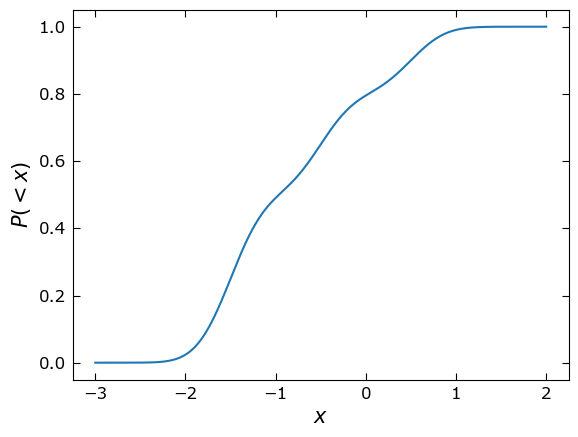

In [3]:
x = np.linspace(-3, 2, 1000)

Px1 = p1 * (1. + special.erf((x - mu1) / sigma1 / np.sqrt(2.))) / 2.  # integral of the normal distribution first gaussian
Px2 = p2 * (1. + special.erf((x - mu2) / sigma2 / np.sqrt(2.))) / 2.  # integral of the normal distribution second gaussian
Px3 = p3 * (1. + special.erf((x - mu3) / sigma3 / np.sqrt(2.))) / 2.  # integral of the normal distribution third gaussian
Px = Px1 + Px2 + Px3

plt.plot(x, Px)
plt.xlabel(r'$x$')
plt.ylabel(r'$P(<x)$');

In [1]:
# Epanechnikov kernel
def k_E(u):
    k = 0.75*(1.-u**2)
    k[k<0] = 0
    return k

# Kernel Density Estimator
def kde(Xdata, Xgrid, h=None, hmin=None, norm=True, kernel=k_E):
    
    # find optimum bandwidth
    if h is None:
        IQR = np.percentile(Xdata,75) - np.percentile(Xdata,25)
        hh = min(np.std(Xdata),IQR/1.34) * 0.9/len(Xdata)**0.2
    else:
        hh = np.copy(h)
    
    # enforce minimum bandwidth
    if hmin is not None:
        if np.ndim(hh) > 0:
            print('kde: increased width to %g for %d of %d data' % (hmin,sum(hh < hmin),len(hh)))
            hh[hh < hmin] = hmin
        else:
            if hh < hmin:
                print('kde: width h_opt = %g increased to %g' % (hh,hmin))
                hh = hmin
        
    k = np.array([ np.sum( kernel((x-Xdata)/hh) / hh ) for x in Xgrid ])
    
    if norm:
        k = k/len(Xdata)
        
    return k

In [5]:
Nsample = 200
np.random_seed = 0

pspline = interpolate.UnivariateSpline(Px, x, s=0)  # create an interpolating function

Px_sample = np.random.random(Nsample)

x_sample = pspline(Px_sample)               # simulated sample

x_sample_randomized = np.array([x_sample[i] + np.random.normal(0.0, 0.1) for i in range(len(x_sample))])

2. Run Gaussian Mixture for this sample with different numbers of modes $K$ and determine the best value of $K$ according to either the AIC and BIC criteria.<br>

In [6]:
def GMM_simple(mu, sig, pk, x):
    
    Kmodes = len(mu)   # number of modes is set by the input array of initial guesses
    logL = 999.
    logL1 = 99.
    iter = 0
    pnk = np.zeros([Kmodes, len(x)])

    while abs(logL - logL1) > 1.e-12:
        
        # E-step
        iter += 1
        pxn = np.zeros(len(x))
        for k in range(Kmodes):
            pxn += pk[k]/np.sqrt(2.*np.pi)/sig[k]*np.exp(-((x-mu[k])/sig[k])**2/2.)

        logL1 = logL
        logL = np.sum(np.log(pxn))

        # M-step
        for k in range(Kmodes):     
            pnk[k] = pk[k]/np.sqrt(2.*np.pi)/sig[k]*np.exp(-((x-mu[k])/sig[k])**2/2.)/pxn

        for k in range(Kmodes):
            w = pnk[k]
            sig2k = np.average((x-mu[k])**2, weights=w)
            sig[k] = np.sqrt(sig2k)
            mu[k] = np.average(x, weights=w)
            pk[k] = np.average(pnk[k])
        
    return logL, mu, sig, pk

K (modes): 1 mus: [-0.88298552] sigmas: [0.81666656]
K (modes): 2 mus: [-1.49333616 -0.24086043] sigmas: [0.32937211 0.67099137]
K (modes): 3 mus: [-1.43108089 -0.42216107  0.48716227] sigmas: [0.35926199 0.20891373 0.29779252]
K (modes): 4 mus: [-1.75697025 -1.28888458 -0.41994158  0.484828  ] sigmas: [0.23215698 0.30683834 0.20377016 0.29916082]


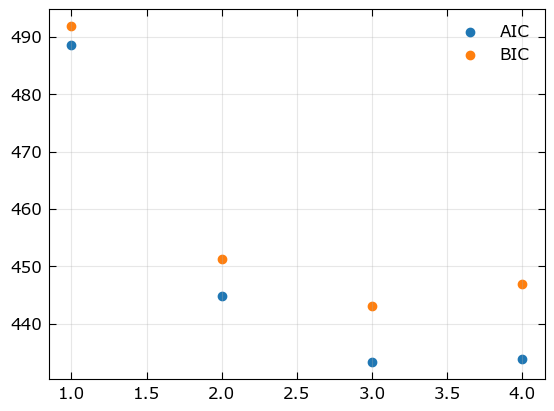

In [7]:
AIC = []
BIC = []

K_list = np.arange(1, 5)

for K in K_list:
    logL, mu, sig, pk = GMM_simple(np.linspace(-2., 0.5, K), np.ones(K), np.full(K, 1./K), x_sample_randomized)
    AIC.append(-2 * logL + 2 * K + 2 * K * (K + 1) / (len(x_sample_randomized) - K - 1))
    BIC.append(-2 * logL + K * np.log(len(x_sample_randomized)))
    # AIC.append(-2 * logL + 2 * K + 2 * K * (K + 1) / (len(x) - K - 1))
    # BIC.append(-2 * logL + K * np.log(len(x)))
    print('K (modes):', K, "mus:", mu, 'sigmas:', sig)

plt.figure()
plt.scatter(K_list, AIC, label="AIC")
plt.scatter(K_list, BIC, label="BIC")
plt.grid(alpha=0.3)
plt.legend()

Most of the times this runs (different random seeds), the lowest criteria is K=3. BIC penalizes larger values of K more than AIC, so usually 3 is the minimum for that criteria, whereas AIC sometimes says K=4 is the optimal K value, even though BIC and our prior knowledge suggest otherwise.

3. Plot the best-fitting model along with the histogram of the generated sample and the original distribution function. Use adaptive KDE histogram.<br>

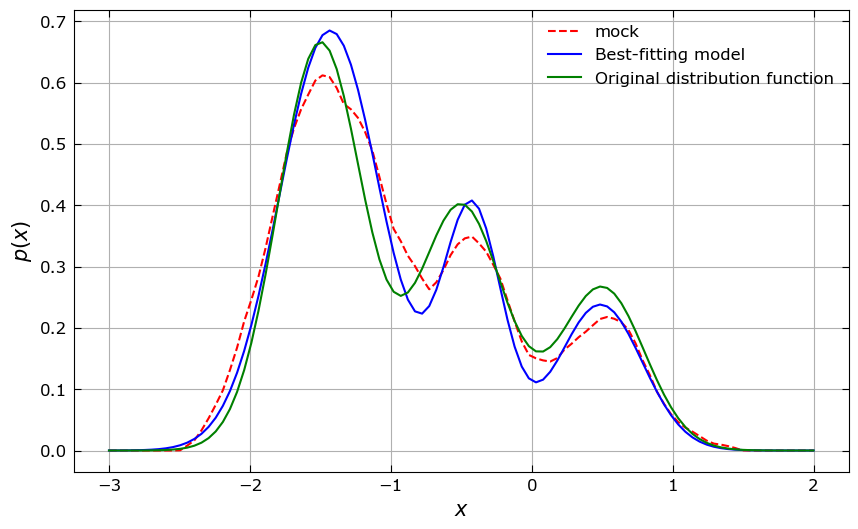

In [8]:
xx = np.linspace(-3, 2, 100)

# probability distribution function of the Gaussian distribution
def pdf_gauss(x, mu, s):
    return np.exp(-((x-mu)/s)**2/2.)/(np.sqrt(2.*np.pi)*s)

K = 3
logL, mu, sig, pk = GMM_simple(np.linspace(-2., 0.5, K), np.ones(K), np.full(K, 1./K), x_sample_randomized)

yy_best_fit = np.zeros(len(xx))
for k in range(len(mu)):
    yy_best_fit += pk[k] * pdf_gauss(xx, mu[k] , sig[k])

yy_original = np.zeros(len(xx))
for k in range(len(mu)):
    yy_original += [p1, p2, p3][k] * pdf_gauss(xx, [mu1, mu2, mu3][k], [sigma1, sigma2, sigma3][k])

plt.figure(figsize=(10, 6))
plt.plot(xx, kde(x_sample_randomized, xx, h=0.3), 'r--', label='mock')
plt.plot(xx, yy_best_fit, color='b', label='Best-fitting model')
plt.plot(xx, yy_original, color='g', label='Original distribution function')

plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.grid()
plt.legend()

In [9]:
sum = 0
for i in range(len(xx)):
    sum += kde(x_sample, xx, h=0.3)[i] * abs(xx[0] - xx[1])
print(sum)

0.9997524973876732


4. Compare the recovered values of the parameters with the original ones and comment on the accuracy of the method. Which parameters are recovered best? Parameters of which of the three modes are recovered best?<br>

In [10]:
K = 3
logL, mu, sig, pk = GMM_simple(np.linspace(-2., 0.5, K), np.ones(K), np.full(K, 1./K), x_sample)

print('Recovered values:   K (modes):', np.round(K, 3), "mus:", np.round(mu, 3), 'sigmas:', np.round(sig, 3), 'pks:', np.round(pk, 3))
print('Original values:   K (modes):', np.round(K, 4), "mus:", np.round([mu1, mu2, mu3], 4), 'sigmas:', np.round([sigma1, sigma2, sigma3], 4), 'pks:', np.round([p1, p2, p3], 4))

Recovered values:   K (modes): 3 mus: [-1.44  -0.423  0.528] sigmas: [0.344 0.227 0.259] pks: [0.605 0.229 0.166]
Original values:   K (modes): 3 mus: [-1.5 -0.5  0.5] sigmas: [0.3 0.3 0.3] pks: [0.5 0.3 0.2]


The means usually seems to be recovered better than the other two parameters. And the first mode usually seems to be the mode recovered best. This makes sense, as it has the largest p_k value, and should stand out more than the others.

5. Generate another sample in a similar way, but with the standard deviation of the added error of 0.2. Comment on the difference in the recovered parameters with the first sample. How does the increased noise affect the reconstruction?

K (modes): 1 mus: [-0.78178472] sigmas: [0.81785149] p_ks: [1.]
K (modes): 2 mus: [-1.50532102 -0.2778751 ] sigmas: [0.2810208  0.67911943] p_ks: [0.41053509 0.58946491]
K (modes): 3 mus: [-1.55926905 -0.75975902  0.33715002] sigmas: [0.24995804 0.39700337 0.38093706] p_ks: [0.37937507 0.36418755 0.25643738]
K (modes): 4 mus: [-1.5606248  -0.71640204  0.33241464  0.96360596] sigmas: [0.2494128  0.45489512 0.26440429 0.08720338] p_ks: [0.36673603 0.41916709 0.18292431 0.03117256]


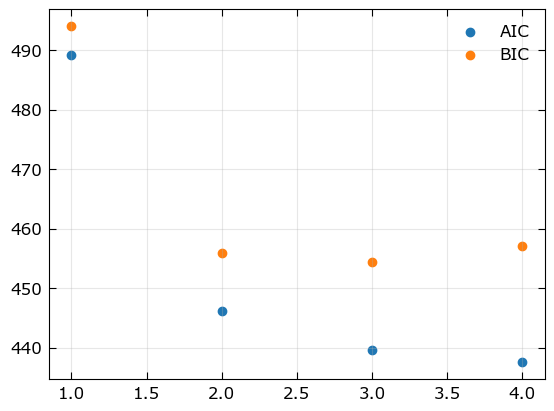

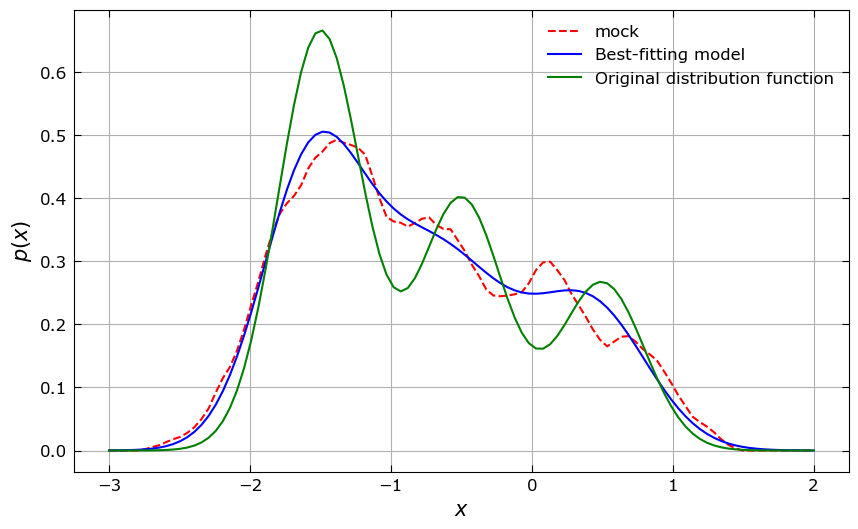

In [13]:
Nsample = 200
np.random_seed = 0

pspline = interpolate.UnivariateSpline(Px, x, s=0)  # create an interpolating function

Px_sample = np.random.random(Nsample)

x_sample = pspline(Px_sample)               # simulated sample

x_sample_randomized = np.array([x_sample[i] + np.random.normal(0.0, 0.2) for i in range(len(x_sample))])

AIC = []
BIC = []

K_list = np.arange(1, 5)

for K in K_list:
    logL, mu, sig, pk = GMM_simple(np.linspace(-2., 0.5, K), np.ones(K), np.full(K, 1./K), x_sample)
    AIC.append(-2 * logL + 2 * K + 2 * K * (K + 1) / (len(x) - K - 1))
    BIC.append(-2 * logL + K * np.log(len(x)))
    print('K (modes):', K, "mus:", mu, 'sigmas:', sig, 'p_ks:', pk)

plt.figure()
plt.scatter(K_list, AIC, label="AIC")
plt.scatter(K_list, BIC, label="BIC")
plt.grid(alpha=0.3)
plt.legend()

xx = np.linspace(-3, 2, 100)

K = 3
logL, mu, sig, pk = GMM_simple(np.linspace(-2., 0.5, K), np.ones(K), np.full(K, 1./K), x_sample_randomized)

yy_best_fit = np.zeros(len(xx))
for k in range(len(mu)):
    yy_best_fit += pk[k] * pdf_gauss(xx, mu[k] , sig[k])

yy_original = np.zeros(len(xx))
for k in range(len(mu)):
    yy_original += [p1, p2, p3][k] * pdf_gauss(xx, [mu1, mu2, mu3][k], [sigma1, sigma2, sigma3][k])

plt.figure(figsize=(10, 6))
plt.plot(xx, kde(x_sample_randomized, xx, h=0.3), 'r--', label='mock')
plt.plot(xx, yy_best_fit, color='b', label='Best-fitting model')
plt.plot(xx, yy_original, color='g', label='Original distribution function')

plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.legend()
plt.grid()

The increased noise definitely decreases the accuracy of the GMM, but that is to be expected, as the modes are not as prominent anymore. The criteria after reconstruction usually indicates more modes, as a wider spread can be rebuilt more accurately with more gaussians.

# Further exploration

K (modes): 1 mus: [-0.78378562] sigmas: [0.82748358]
K (modes): 2 mus: [-1.53115656 -0.3366976 ] sigmas: [0.28823817 0.7145734 ]
K (modes): 3 mus: [-1.48845728 -0.49513096  0.54441319] sigmas: [0.31247524 0.31546434 0.30708953]
K (modes): 4 mus: [-1.58928569 -1.24546952 -0.53277843  0.55183115] sigmas: [0.27016857 0.14072228 0.34552053 0.30389453]


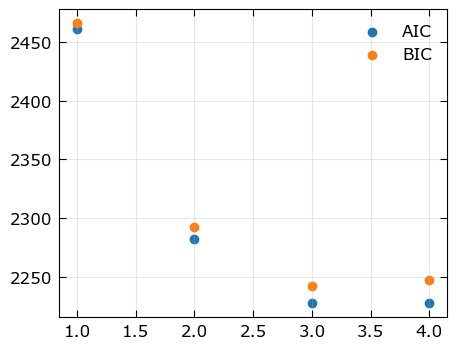

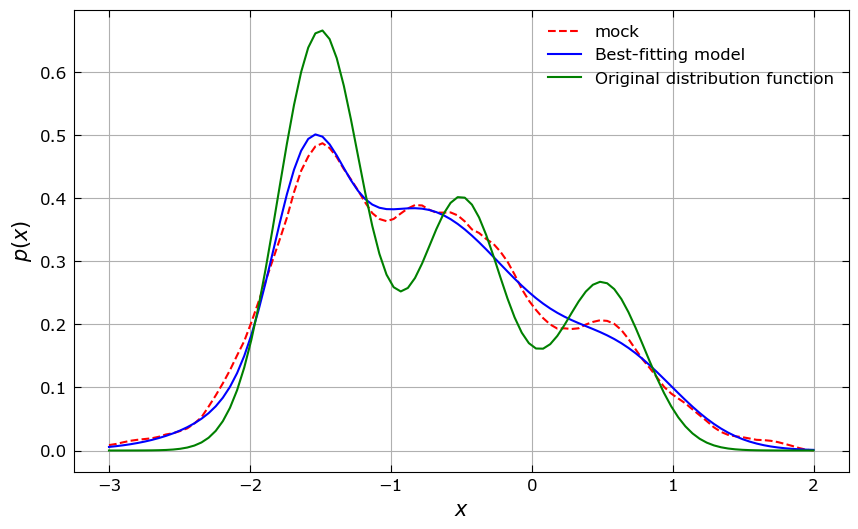

In [15]:
Nsample = 1000
np.random_seed = 0

pspline = interpolate.UnivariateSpline(Px, x, s=0)  # create an interpolating function

Px_sample = np.random.random(Nsample)

x_sample = pspline(Px_sample)               # simulated sample

x_sample_randomized = np.array([x_sample[i] + np.random.normal(0.0, 0.3) for i in range(len(x_sample))])

AIC = []
BIC = []

K_list = np.arange(1, 5)

for K in K_list:
    logL, mu, sig, pk = GMM_simple(np.linspace(-2., 0.5, K), np.ones(K), np.full(K, 1./K), x_sample)
    AIC.append(-2 * logL + 2 * K + 2 * K * (K + 1) / (len(x) - K - 1))
    BIC.append(-2 * logL + K * np.log(len(x)))
    print('K (modes):', K, "mus:", mu, 'sigmas:', sig)

plt.figure(figsize=(5, 4))
plt.scatter(K_list, AIC, label="AIC")
plt.scatter(K_list, BIC, label="BIC")
plt.grid(alpha=0.3)
plt.legend()

xx = np.linspace(-3, 2, 100)

K = 3
logL, mu, sig, pk = GMM_simple(np.linspace(-2., 0.5, K), np.ones(K), np.full(K, 1./K), x_sample_randomized)

yy_best_fit = np.zeros(len(xx))
for k in range(len(mu)):
    yy_best_fit += pk[k] * pdf_gauss(xx, mu[k] , sig[k])

yy_original = np.zeros(len(xx))
for k in range(len(mu)):
    yy_original += [p1, p2, p3][k] * pdf_gauss(xx, [mu1, mu2, mu3][k], [sigma1, sigma2, sigma3][k])

plt.figure(figsize=(10, 6))
plt.plot(xx, kde(x_sample_randomized, xx, h=0.3), 'r--', label='mock')
plt.plot(xx, yy_best_fit, color='b', label='Best-fitting model')
plt.plot(xx, yy_original, color='g', label='Original distribution function')

plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.legend()
plt.grid()

200 points is a pretty small number of points to draw our mock distribution from. By increasing the number of points drawn from our distribution (to 1,000), I was able to recover the optimal K value of 3 even after increasing the randomization of our xsample (stdev 0.3). It is important to note however, that because our noise was higher, the p values decreased for all 3 modes, but that is not the fault of GMM, just the randomization.

# Concluding Assessment

Numerical methods which worked or did not work in this project:
* The method we took to create a mock sample worked quite well (i.e. the spline we fitted to the CDF did a great job of getting the three gaussians sampled together).
* Gaussian mixture modeling itself worked relatively well; as it usually recovered the correct K value of 3. However, when I ran this code with different random seeds, the AIC and BIC criteria occasionally recovered an optimal K value of greater than 4. This is likely due to the random noise introduced by us, and shows that GMM is not perfect, just one metric we can use to try recovering the K value.

Lessons learned:
* GMM is hlepful when trying to determine how many modes a distribution has, but there are also limits to how much trust you should put in it. Random noise could allow the criteria to recover an optimal K value that just isn't true. So it's necessary to keep this in mind and not automatically trusting what this method returns.

Further code improvements I could make with significantly more effort:
* I could have done what I did in my further exploration, but over many more iterations of noise and sampled points. That would have shown a potential relationship between how many points were necessary, relative to the noise added, to successfully reconstruct the original distribution.
